In [44]:
%pylab inline --no-import-all
import math
import george
import numpy as np
import scipy.stats as ss

import matplotlib.ticker as ticker
import matplotlib.cm as cmap

from george.kernels import ExpSquaredKernel

Populating the interactive namespace from numpy and matplotlib


In [45]:
truth_step_size = 0.1
smeared_step_size = 1.
mean = 50.
init_Amp = 100.
init_lengthscale = 1.
gaussian_width = 2.

truth_steps=np.arange(70, 200, truth_step_size)
smeared_steps=np.arange(100, 170, smeared_step_size)

pull=[]

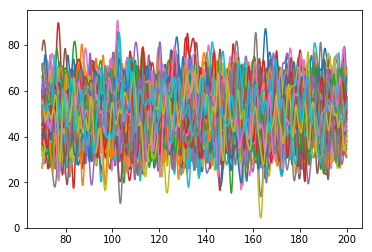

In [46]:
initial_kernel = init_Amp * ExpSquaredKernel(init_lengthscale)
initial_gp = george.GP(initial_kernel, mean=mean)
initial_gp.compute(truth_steps)
samples=initial_gp.sample(truth_steps,100)
for s in samples:
    plt.plot(truth_steps,s)

In [47]:
def draw_pulls(pulls, amp):
    bins=np.linspace(-2,2,50)

    pull_mean = np.mean(pulls)
    pull_std = np.std(pulls)

    n,_,_=plt.hist(pulls, bins=bins, normed=True)
    plt.plot(bins, ss.norm.pdf(bins, pull_mean, pull_std), c='r', linewidth='3')
    plt.xlabel("(GP-Smeared)/GP Uncertainty", fontsize=20)
    plt.title("Kernel Amplitude = "+str(amp), fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)

In [48]:
def smear(s):
    smeared_counts=np.zeros(len(smeared_steps))
    for xi, x in enumerate(smeared_steps):
        gaus = truth_step_size*ss.norm.pdf(x, truth_steps, gaussian_width)
        smeared_counts[xi]=np.sum(s*gaus)
    noisy_smeared_counts=np.random.poisson(smeared_counts)
    return smeared_counts, noisy_smeared_counts

In [49]:
def makeGP(counts, amp_scale=1.):
    kernel = amp_scale*init_Amp * ExpSquaredKernel(gaussian_width*np.sqrt(2))
    gp = george.GP(kernel, mean=mean)
    gp.compute(smeared_steps, yerr=np.sqrt(counts))
    meanGP, covGP = gp.predict(counts, smeared_steps)
    stdGP = np.sqrt(np.diag(covGP))
    return meanGP, stdGP

In [50]:
for samp in samples:
    smeared_counts, noisy_smeared_counts = smear(samp)
    meanGP, stdGP = makeGP(noisy_smeared_counts)
    pull+=list((meanGP-noisy_smeared_counts)/stdGP)

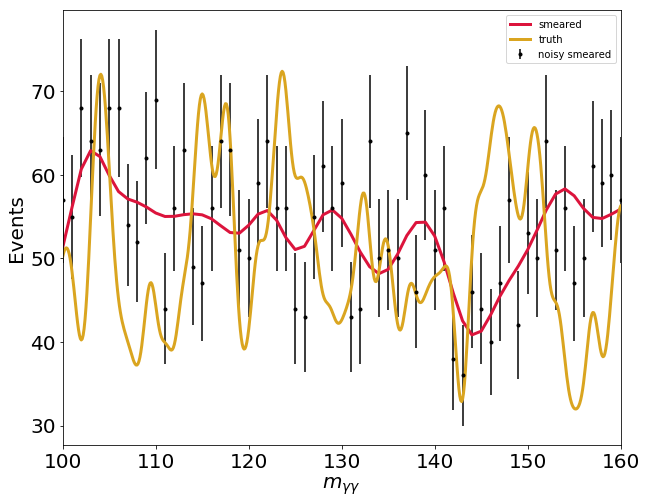

In [51]:
plt.figure(figsize(10,8))
plt.ylabel('Events', fontsize=20)
plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
plt.xlim([100,160])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)


plt.plot(smeared_steps,smeared_counts, c='crimson', linewidth=3, label="smeared")
plt.errorbar(smeared_steps,noisy_smeared_counts, yerr=np.sqrt(noisy_smeared_counts), markersize = '3', marker='o', ls='None', c='black', label="noisy smeared")
plt.plot(truth_steps, samples[1], c='goldenrod', linewidth=3, label="truth")
plt.legend()

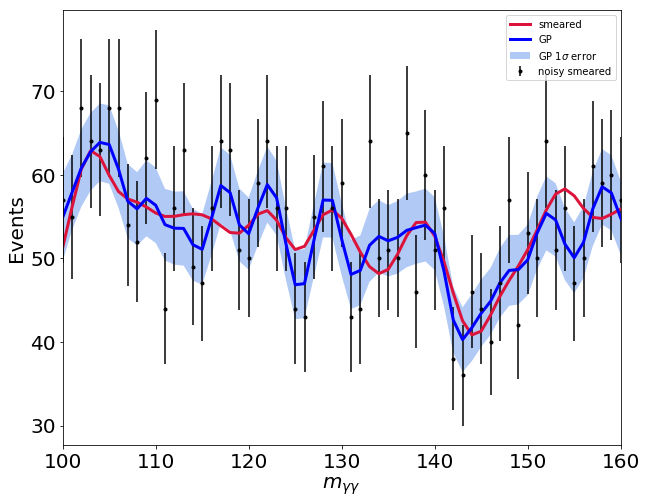

In [52]:
plt.figure(figsize(10,8))
plt.ylabel('Events', fontsize=20)
plt.xlabel(r'$m_{\gamma\gamma}$', fontsize=20)
plt.xlim([100,160])
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', labelsize=20)

plt.plot(smeared_steps, smeared_counts, c='crimson', linewidth=3, label='smeared')
plt.plot(smeared_steps, meanGP, c='b', linewidth=3, label="GP")
plt.fill_between(smeared_steps, meanGP-stdGP, meanGP+stdGP, facecolor='cornflowerblue', alpha=0.5, label=r"GP $1\sigma$ error")
plt.errorbar(smeared_steps,noisy_smeared_counts, yerr=np.sqrt(noisy_smeared_counts), marker='o', markersize='3', ls='None', c='black', label="noisy smeared")
plt.legend()

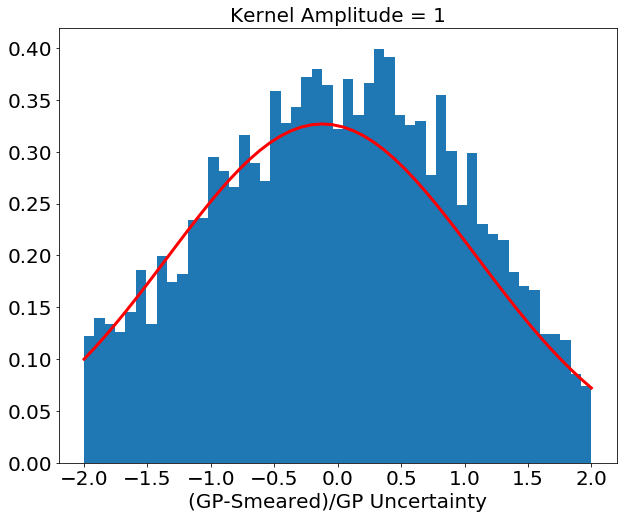

In [53]:
draw_pulls(pull, 1)

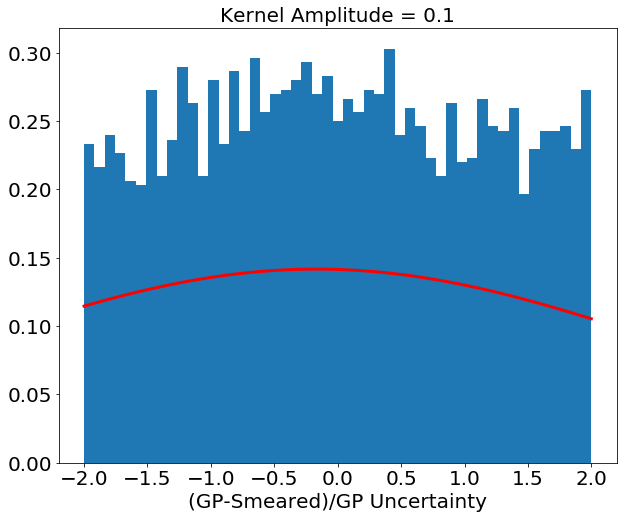

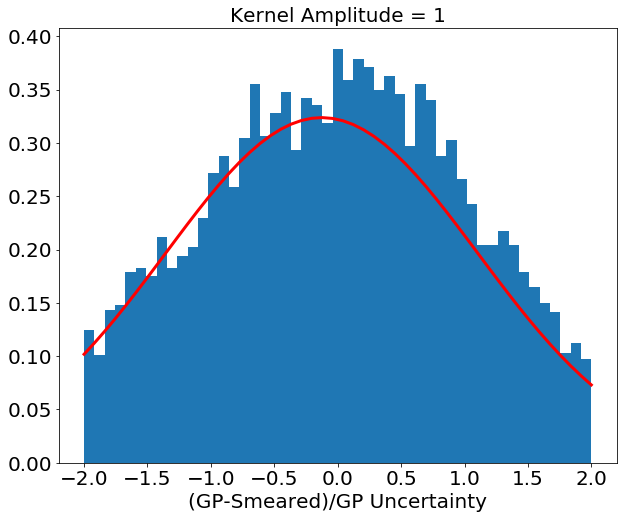

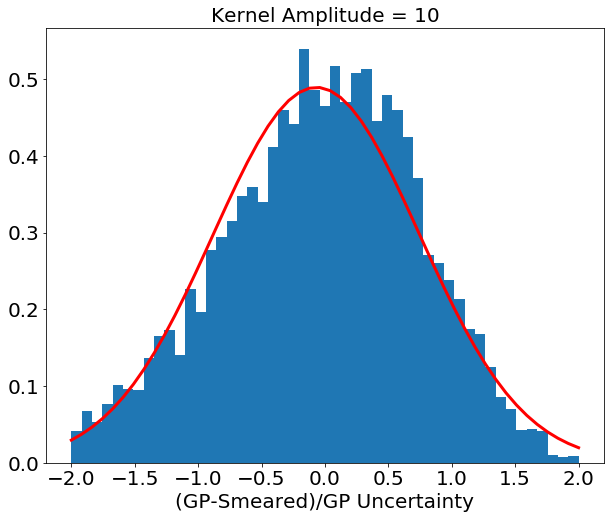

In [54]:
ampscales=[0.1,1,10]
pulls={}
for amp in ampscales:
    pulls[amp]=[]
    for samp in samples:
        smeared_counts, noisy_smeared_counts = smear(samp)
        meanGP, stdGP = makeGP(noisy_smeared_counts, amp)
        pulls[amp]+=list((meanGP-noisy_smeared_counts)/stdGP)
    plt.figure()
    draw_pulls(pulls[amp], amp)